In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [2]:
%%HTML
<style type="text/css">
table, td{
    border-style: solid;
}
th {
  background-color: #4CAF50;
  color: white;
}
tr:nth-child(even) {background-color: #f0f0f0;}
tr:hover {background-color: #4CAF50;}

In [3]:
from pypower.idx_bus import PD, QD, VM, VA, GS, BUS_TYPE, PQ, REF
from pypower.idx_brch import PF, PT, QF, QT
from pypower.idx_gen import PG, QG, VG, QMAX, QMIN, GEN_BUS, GEN_STATUS
from pypower.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
from pypower.idx_brch import F_BUS, T_BUS, RATE_A, RATE_B, PF, QF, PT, QT, MU_SF, MU_ST
from pypower.idx_gen import GEN_BUS, PG, QG, VG, MU_PMAX, MU_PMIN, MU_QMAX, MU_QMIN
from pypower.idx_cost import MODEL, PW_LINEAR, NCOST

from pypower.api import makeYbus
from pypower.api import case30pwl, case30Q 
from pypower.api import case30, ppoption, runpf, printpf, runopf
from pypower.t import t_loadcase, t_auction_case
from pypower.ext2int import ext2int
from scipy.optimize import minimize, nnls, linprog
ppc = case30()
#ppc_ = loadcase(ppc)
#ppc = ext2int(ppc)
ppopt = ppoption(PF_ALG=1, RETURN_RAW_DER=True, OPF_FLOW_LIM=0)
#ppopt

In [4]:
#!pip install pandapower --user

In [5]:
#Plotting net with pandapower tools
#from pandapower.plotting.collections import create_bus_collection
#from pandapower.plotting.collections import create_line_collection
#from pandapower.plotting.collections import draw_collections
#from pandapower.plotting.collections import create_annotation_collection
#from pandapower.plotting.collections import create_gen_collection
#from pandapower.plotting.collections import create_ext_grid_collection
import pandapower.converter as pc
from pandapower.networks import case30 as case30_panda
net = case30_panda()

In [6]:
gens = ppc['gen'][:, 0]

load_list = []

for bus_str in ppc['bus']:
    tmp = np.zeros(21)
    if bus_str[0] in [7., 15., 30.]:
        if bus_str[0] not in gens:
            #print('load #%d' % bus_str[0])
            tmp[0] = bus_str[0]

            tmp[1] = -30.#bus_str[2]
            tmp[2] = -15.#bus_str[3]

            tmp[3] = -0.0001
            tmp[4] = -15.

            tmp[5] = bus_str[7]
            tmp[6] = 100.

            tmp[7] = 1.

            #fixed here
            tmp[8] = -0.0001
            tmp[9] = -30.

            bus_str[2], bus_str[3] = 0., 0.
            load_list.append(tmp)

ppc['gen'] = np.concatenate((ppc['gen'], np.array(load_list)))

In [7]:
alpha = 1.0
#bound max flow 3 <-> 11
ppc['branch'][14][5] *= alpha
#bound max flow 9 <-> 16
ppc['branch'][25][5] *= alpha
#bound max flow 27 <-> 26
#ppc['branch'][35][5] *= alpha
#bound max flow 18 <-> 19
#ppc['branch'][23][5] *= alpha
#bound max flow 22 <-> 23
ppc['branch'][31][5] *= alpha

## Data preparation to fulfil the task

Bus data:

<table>
    <tr>
            <td> $bus_i$ </td>
            <td> type </td>
            <td> $P_d$ </td>
            <td> $Q_d$ </td>
            <td> $G_s$ </td>
            <td> $B_s$ </td>
            <td> area </td>
            <td> $V_m$ </td>
            <td> $V_a$ </td>
            <td> base~KV </td>
            <td> zone </td>
            <td> $V_{max}$ </td>
            <td> $V_{min}$ </td>
    </tr>
</table>

Generator data:

<table>
    <tr>
            <td> $bus$ </td>
            <td> $P_g$ </td>
            <td> $Q_g$ </td>
            <td> $Q_{max}$ </td>
            <td> $Q_{min}$ </td>
            <td> mBase </td>
            <td> status </td>
            <td> $P_{max}$ </td>
            <td> $P_{min}$ </td>
            <td> $\ldots$ </td>
    </tr>
</table>

Generator cost data has the following structure:

<table>
    <tr>
            <td> 1 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $x_1$ </td>
            <td> $y_1$ </td>
            <td> $\ldots$ </td>
            <td> $x_n$ </td>
            <td> $y_n$ </td>
    </tr>
    <tr>
            <td> 2 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $c_{n - 1}$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $c_0$ </td>
    </tr>
</table>

Convert cost function to linear changing the order of polynom to 1

In [8]:
ppc['gencost'][:,3] = np.ones(ppc['gencost'].shape[0]) * 2
ppc['gencost'] = ppc['gencost'][:,[0,1,2,3,5,6]]
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0


In [9]:
cost_list = []

for load in load_list:
    cost_list.append(np.array([2., 0., 0., 2., -10., 0]))
    
ppc['gencost'] = np.concatenate((ppc['gencost'], np.array(cost_list)))

In [10]:
#ppc['gencost'][:, 4] = np.zeros(ppc['gencost'].shape[0])
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0
6,2.0,0.0,0.0,2.0,-10.00,0.0
7,2.0,0.0,0.0,2.0,-10.00,0.0
8,2.0,0.0,0.0,2.0,-10.00,0.0


Also it contains only generation costs, to satisfy welfare cost function:

\begin{equation}
f = \sum\limits_{d \in {\cal D}} C_dP_d - \sum\limits_{g \in {\cal G}} C_gP_g = {\bf C}_d^{\top}{\bf P}_d - {\bf C}_g^{\top}{\bf P}_g\to \max
\end{equation}

From `MATPOWER` documentation the standard OPF problem takes the following form:

\begin{align}
\min_x~& f(x)\\
s.t.~&g(x) = 0\\
&h(x) \leq 0\\
x_{{\rm min}} &\leq x \leq x_{{\rm max}}
\end{align}

Then

\begin{equation}
f = {\bf C}_g^{\top}{\bf P}_g - {\bf C}_d^{\top}{\bf P}_d \to \min
\end{equation}


In [11]:
pd.DataFrame(ppc['gen'])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,23.54,0.0,150.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,60.97,0.0,60.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,21.59,0.0,62.5000,-15.0,1.0,100.0,1.0,50.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.0,26.91,0.0,48.7000,-15.0,1.0,100.0,1.0,55.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,19.20,0.0,40.0000,-10.0,1.0,100.0,1.0,30.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.0,37.00,0.0,44.7000,-15.0,1.0,100.0,1.0,40.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,15.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### letting generators generate more ###
#ppc['gen'][:6,[8]] = 30000000
#ppc['gen'][:6,[8]]

In [13]:
### isolating the generators ###
branches_for_27 = [(24, 25), (24, 35), (27, 28)]
branches_for_22 = [(22, 24), (10, 20), (6, 10), (6, 9), (6, 8)]
branches_for_23 = [(12, 14), (12, 15)]
branches_for_13 = [(10, 17), (4, 12)]
branches_for_11 = [(1, 2), (3, 4)]
branches_for_isolation_ = np.array([branches_for_13, branches_for_23, branches_for_22, branches_for_27])
#branches_for_isolation_ = [[(4, 12), (23, 24)]]
branches_for_isolation = []
for list_ in branches_for_isolation_:
    for tuple_ in list_:
        branches_for_isolation.append(tuple_)
#print(branches_for_isolation)
for branch in ppc['branch']:
    for branch_to_isolate in branches_for_isolation:
        b   = branch
        bti = branch_to_isolate
        if (b[0] == bti[0] and b[1] == bti[1]):
            branch[5] *= 1.0
        elif (b[0] == bti[1] and b[1] == bti[0]):
            print(bti)
        #lse:
            #branch[5] = 10000


(27, 28)


In [14]:
pd.DataFrame(ppc['branch'][:,[0,1,5]]).T

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1.0,1.0,2.0,3.0,2.0,2.0,4.0,5.0,6.0,6.0,...,23.0,24.0,25.0,25.0,28.0,27.0,27.0,29.0,8.0,6.0
1,2.0,3.0,4.0,4.0,5.0,6.0,6.0,7.0,7.0,8.0,...,24.0,25.0,26.0,27.0,27.0,29.0,30.0,30.0,28.0,28.0
2,130.0,130.0,65.0,130.0,130.0,65.0,90.0,70.0,130.0,32.0,...,16.0,16.0,16.0,16.0,65.0,16.0,16.0,16.0,32.0,32.0


In [15]:
from drawings import draw_net

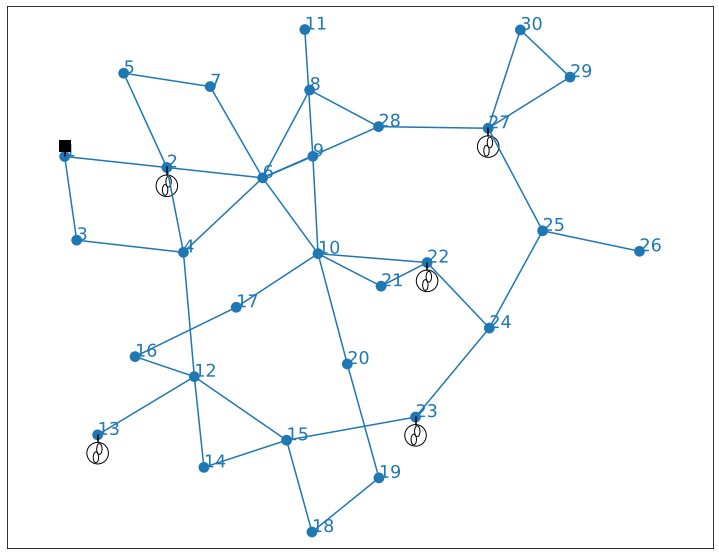

In [16]:
draw_net(net)

In [17]:
ppc['gencost'][:,4] = [900, 1000, 1100, 1200, 13000, 14000, -40000, -40000, -40000]

In [18]:
pd.DataFrame([list(pd.DataFrame(ppc['gen']).T.loc[0].values), list(pd.DataFrame(ppc['gencost']).T.loc[4].values)], index=['Buses', 'Costs'])

,0,1,2,3,4,5,6,7,8
Buses,1.0,2.0,22.0,27.0,23.0,13.0,7.0,15.0,30.0
Costs,900.0,1000.0,1100.0,1200.0,13000.0,14000.0,-40000.0,-40000.0,-40000.0


In [19]:
results = runopf(ppc, ppopt)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 1.86 seconds
Objective Function Value = 227147.85 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -140.0 to 405.9
Generators         9     On-line Capacity       335.0        -140.0 to 405.9
Committed Gens     9     Generation (actual)    151.2              93.3
Loads             17     Load                   147.6              91.9
  Fixed           17       Fixed                147.6              91.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)      

In [20]:
pd.DataFrame(results['branch'][:,[F_BUS, T_BUS, RATE_A, RATE_B, PF, QF, PT, QT, MU_SF, MU_ST]], 
             columns=['F_BUS', 'T_BUS', 'RATE_A', 'RATE_B', 'PF', 'QF', 'PT', 'QT', 'MU_SF', 'MU_ST'])

,F_BUS,T_BUS,RATE_A,RATE_B,PF,QF,PT,QT,MU_SF,MU_ST
0,1.0,2.0,130.0,130.0,5.493371e+01,14.387447,-5.426769e+01,-15.275048,0.000000,0.000000
1,1.0,3.0,130.0,130.0,2.506629e+01,-1.157324,-2.474626e+01,0.431888,0.000000,0.000000
2,2.0,4.0,65.0,65.0,1.246805e+01,-9.426535,-1.232319e+01,7.938189,0.000000,0.000000
3,3.0,4.0,130.0,130.0,2.234626e+01,-1.631888,-2.229396e+01,1.841107,0.000000,0.000000
4,2.0,5.0,130.0,130.0,6.176861e+00,-1.390010,-6.156504e+00,-0.408455,0.000000,0.000000
5,2.0,6.0,65.0,65.0,1.392278e+01,-6.608402,-1.377887e+01,5.151473,0.000000,0.000000
6,4.0,6.0,90.0,90.0,8.473338e+00,10.566461,-8.454164e+00,-10.489763,0.000000,0.000000
7,5.0,7.0,70.0,70.0,6.156504e+00,0.586645,-6.135703e+00,-1.470252,0.000000,0.000000
8,6.0,7.0,130.0,130.0,-6.068339e+00,12.771204,6.135603e+00,-13.529747,0.000000,0.000000
9,6.0,8.0,32.0,32.0,2.391432e+01,21.262765,-2.380615e+01,-20.830062,223523.848734,0.000000


In [21]:
print(branches_for_isolation)
pd.DataFrame(ppc['branch'], columns=['fbus', 'tbus', 'r', 'x', 'b', 'rateA', 'rateB', 'rateC', 'ratio', 'angle', 'status', 'angmin', 'angmax', 'wat','wat','wat','wat','wat','wat','wat','wat'])

[(10, 17), (4, 12), (12, 14), (12, 15), (22, 24), (10, 20), (6, 10), (6, 9), (6, 8), (24, 25), (24, 35), (27, 28)]


,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,...,angmin,angmax,wat,wat,wat,wat,wat,wat,wat,wat
0,1.0,2.0,0.02,0.06,0.03,130.0,130.0,130.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,0.05,0.19,0.02,130.0,130.0,130.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,4.0,0.06,0.17,0.02,65.0,65.0,65.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,4.0,0.01,0.04,0.00,130.0,130.0,130.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,5.0,0.05,0.20,0.02,130.0,130.0,130.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,6.0,0.06,0.18,0.02,65.0,65.0,65.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,6.0,0.01,0.04,0.00,90.0,90.0,90.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.0,7.0,0.05,0.12,0.01,70.0,70.0,70.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6.0,7.0,0.03,0.08,0.01,130.0,130.0,130.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,6.0,8.0,0.01,0.04,0.00,32.0,32.0,32.0,0.0,0.0,...,-360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
dg, dgeq = utils.get_Jac(ppc, ppopt, results)

In [23]:
results['gen'][:,LAM_P]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
results['gen'][:,0]

array([ 1.,  2., 22., 27., 23., 13.,  7., 15., 30.])

# Testing Olya's solution

In [25]:
dgT, dgeqT = utils.get_Jac(ppc, ppopt, results)
muls = utils.get_muls(results)
utils.is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #22	 C_g=1100.000000
Price forming bus #27	 C_g=1200.000000
Price forming bus #23	 C_g=13000.000000


[21, 26, 22]

\begin{equation}
\mu = 
\begin{pmatrix}
{\bf 0}\\
\mu^{\max} - \mu^{\min}
\end{pmatrix}
\end{equation}


$$\sigma = (\sigma_{from}, \sigma_{to})^{\top}$$
as according to the original code (opf_consfcn)
$${\bf J}_S^T = ({\bf J}_{S~from}, {\bf J}_{S~to})$$

In [26]:
sigma = np.concatenate((muls['mu_s_from'], muls['mu_s_to']))

Let's obtain FOC for our OPF

\begin{align}
&\left(\frac{\partial L}{\partial {\bf X}}\right)^{\top} = {\bf J}^{\top}{\lambda} + {\bf J}_S^{\top}{\sigma} + {\mu} = 0\\
&\left(\frac{\partial L}{\partial {\bf P}_g}\right)^{\top} = {\bf C}_g - { \lambda}^P + {\pi}^{\max} - {\pi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf P}_d}\right)^{\top} = -{\bf C}_d + { \lambda}^P + {\psi}^{\max} - {\psi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf Q}_g}\right)^{\top} = {\bf 0} - { \lambda}^Q + {\rho}^{\max} - { \rho}^{\min} = 0
\end{align}

From here we should fix {\lambda}^Q as we don't want to change ${\rho}^{\max}, { \rho}^{\min}$ and following we should recompute costs after obtaining new ${ \lambda}^P$ with ${\pi}^{\max}, {\pi}^{\min}, {\psi}^{\max}, {\psi}^{\min}$ from original solution.

In [27]:
idx_sigma = sigma > 0
#C = utils.gen_C_vec(results['gen'], results['gencost'])
#так как у нас лоады это отрицательные генераторы
#надо нормально написать пересчет костов
#pi_psi = muls['mu_p_max'] - muls['mu_p_min']

In [28]:
from utils import Median_func
from scipy.optimize import LinearConstraint



In [38]:
from solution_options import set_options, set_alg, check_opt_alg

sol_opt = set_options()
alg = set_alg()

check_opt_alg(sol_opt, alg)

threshold=2000

BoundedLS not for mode = 1


In [39]:
sol_opt

{'mode': 1, 'lam_q': 1, 'mu': 2, 'sigma': 2, 'pi_psi': 2, 'rho': 0}

In [40]:

from solver import *
from utils import Rand_replace, Median_func
res_struct = Solve(dgT, dgeqT, results, threshold,
                   replace_func=Rand_replace,
                   opt=sol_opt,
                   verbose=True,
                   alg=alg, alpha=0.2, beta=0.8)

#Var = 205
#Eq = 60
Underdetermined:  True
{'lam_p': 21, 'pi_max': 3, 'pi_min': 3, 'psi_max': 3, 'psi_min': 3, 'lam_q': 30, 'sigma': 82, 'mu': 60}
Setting Error


In [41]:
results['bus'][:, LAM_P]

array([  1010.53643876,    935.73392642,   1334.60423321,   1403.09157584,
          688.44720882,    419.30879964,    525.58057231, 149050.63866149,
         7388.88016709,  10981.02858956,   7388.88016709,   7665.17518201,
         7665.17518191,   8901.92306274,   9770.62599002,   9238.82175097,
        10596.70399858,  10554.47248843,  10923.38864546,  10972.83131441,
        20389.54935475,   1100.00000364,  12999.99998966,  16494.05303819,
        47108.70710391,  48062.24852357,   1200.00000041,  30341.26151749,
         1171.32768115,   1184.05469167])

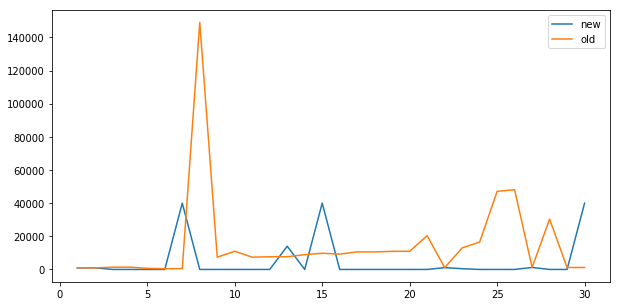

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(results['bus'][:, 0], results['new_lam'], label='new')
plt.plot(results['bus'][:, 0], results['bus'][:, LAM_P], label='old')
plt.legend(loc='best')

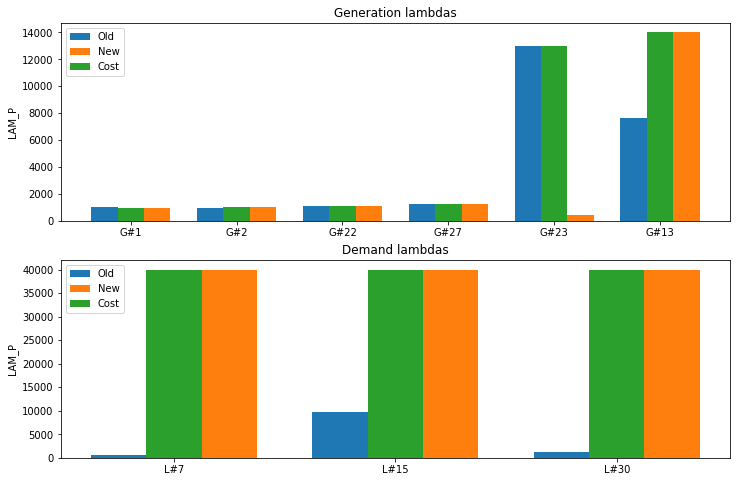

In [43]:
loads = np.setdiff1d(results['gen'][:, 0], gens)

ind = np.arange(len(gens))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
rects1 = ax[0].bar(ind - width, results['bus'][:, LAM_P][gens.astype(int) - 1], width,
                label='Old')
rects2 = ax[0].bar(ind + width, results['new_lam'][gens.astype(int) - 1], width,
                label='New')
rects2 = ax[0].bar(ind, results['gencost'][:, 4][results['gencost'][:, 4] > 0], width,
                label='Cost')

ax[0].set_ylabel('LAM_P')
ax[0].set_title('Generation lambdas')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(('G#%d' % i for i in gens))
ax[0].legend()

ind = np.arange(len(loads))
rects1 = ax[1].bar(ind - width, results['bus'][:, LAM_P][loads.astype(int) - 1], width,
                label='Old')
rects2 = ax[1].bar(ind + width, results['new_lam'][loads.astype(int) - 1], width,
                label='New')

rects2 = ax[1].bar(ind, -results['gencost'][:, 4][~(results['gencost'][:, 4] > 0)], width,
                label='Cost')

ax[1].set_ylabel('LAM_P')
ax[1].set_title('Demand lambdas')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(('L#%d' % i for i in loads))
ax[1].legend()


In [35]:
results['new_lam'][loads.astype(int) - 1] - results['bus'][:, LAM_P][loads.astype(int) - 1]

array([39474.41942769, 30229.37400998, 38815.94530833])

In [36]:
all_sets = create_all_pos_settings()

In [37]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(all_sets):
    try:
        check_opt_alg(i[0], i[1])
        res_struct = Solve(dgT, dgeqT, results, threshold, 
                           replace_func=Rand_replace, 
                           opt=i[0], 
                           alg=i[1], 
                           verbose=False, 
                           alpha=0.2, beta=0.8)
    except:
        print(i)
        raise KeyboardInterrupt

/home/rectangle/Documents/study/sk/Industrial_Immersion_ATS/pandapower/after/solver_utils.py:63: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(A, b)


({'mode': 0, 'lam_q': 1, 'mu': 0, 'sigma': 2, 'pi_psi': 1, 'rho': 0}, 3)


KeyboardInterrupt: 

In [ ]:
results['new_lam']